# Introduction

MedGemma is a multimodal specialized model from Google DeepMind. It is based on Gemma 3 model.

Few resources available:
* Model on Google Cloud Model Garden: [MedGemma](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/medgemma)
* Model on Hugging Face: [MedGemma](https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4)
* GitHub repository (supporting code, Colab notebooks, discussions, and issues): [MedGemma](https://github.com/google-health/medgemma)

# Prerequisites

Gemma 3 is supported from transformers 4.50.0. If your Notebook is preinstalled with an earlier version, you will need to upgrage transformers library:

```python
pip install -U transformers
```

In [1]:
import os
import torch
import requests
from PIL import Image
from transformers import pipeline
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

2025-05-25 11:53:30.118927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748174010.344952      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748174010.413974      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load the model

We will load the model from HuggingFace, since at the time when this Notebook was written, the model is not yet published on Kaggle.


In [2]:

user_secrets = UserSecretsClient()
hugging_face_token = user_secrets.get_secret("HUGGINGFACE_TOKEN")

In [3]:

login(hugging_face_token)

In [4]:
pipe = pipeline(
    "image-text-to-text",
    model="google/medgemma-4b-it",
    torch_dtype=torch.bfloat16,
    device="cuda",
)

config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda


# Load a medical image

We will initially test the model with the suggested (in HuggingFace documentation of the model) open source image from Wikipedia.

In [5]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png"
image = Image.open(requests.get(image_url, headers={"User-Agent": "example"}, stream=True).raw)

Let's show the image.

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Chest_Xray_PA_3-8-2010.png" width=400></img>

# Query the model

We prepare the query, specifying the system prompt (using system role) and, using the user role, the instructions for the model as well as the image to interpret.

In [6]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe this X-ray"},
            {"type": "image", "image": image},
        ]
    }
]

We then run the query.

In [7]:
output = pipe(text=messages, max_new_tokens=256)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


Let's show the text as markdown.

In [8]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the provided X-ray image, here's a description:

**Overall Impression:**

The image shows a chest X-ray with unremarkable findings. It appears to be a normal study, likely obtained for routine screening or follow-up.

**Key Structures and Observations:**

*   **Bones:** The ribs, clavicles, and scapulae appear intact, with no visible fractures or significant degenerative changes. The vertebral bodies are in normal alignment. The shoulders are well-defined.
*   **Lungs:** The lungs are clear bilaterally. There is no evidence of consolidation, nodules, masses, or pleural effusions. The cardiomediastinal silhouette appears normal in size and position. The heart size is likely within normal limits, although precise assessment requires measuring the cardiothoracic ratio (CTR). The mediastinum is not widened.
*   **Diaphragm:** The diaphragm is well-defined and appears in the correct position.
*   **Soft Tissues:** There is no evidence of subcutaneous emphysema or significant soft tissue abnormalities.

**Possible Limitations:**

*   The image quality is adequate for a general assessment, but subtle findings might be missed.

**Conclusion:**

The chest X-ray shows no acute cardiop

# Interpret malignant image from a Kaggle dataset

We load now an image from a Kaggle dataset with melanoma cases.

In [9]:
image_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/malignant/melanoma_5003.jpg"
image = Image.open(image_path)

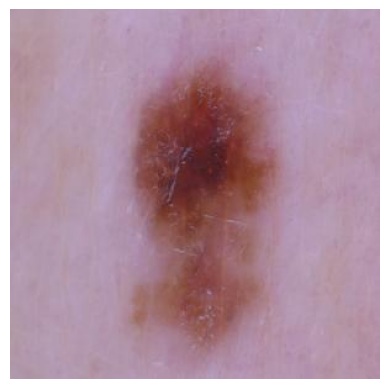

In [10]:

plt.imshow(image)
plt.axis('off') 
plt.show()

In [11]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this image."},
            {"type": "image", "image": image},
        ]
    }
]

In [12]:
output = pipe(text=messages, max_new_tokens=256)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


In [13]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Okay, I will analyze the image to the best of my ability, keeping in mind I am an AI and cannot provide a definitive diagnosis.  I will be looking for characteristics that might suggest a benign or malignant lesion, considering the limitations of a single image and the need for clinical context.

**Image Characteristics:**

*   **Appearance:** The image shows a central, somewhat irregular dark area with a lighter, possibly slightly more defined, margin. The overall density seems uniform, but there could be subtle variations in texture.

*   **Size:** It's difficult to precisely measure the size without a scale, but the lesion appears to be of moderate size, approximately 5-7 mm.

*   **Shape:** The shape is somewhat irregular and not perfectly round or oval. The "dark area" appears to be more central and the edges are not sharply defined.

**Potential Considerations:**

Given these characteristics, some possibilities to consider include:

*   **Benign Lesions:**

    *   **Pigmented Nevus (Mole):** This is the most common type of mole. It typically presents as a round or oval, brown or black macule with a well-defined border. The color can vary, but it's usually a

# COVID induced pneumonia

Let's also analyse some COVID induced pneumonia images.

In [14]:
image_path = "/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/PNEUMONIA/7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png"
image = Image.open(image_path)

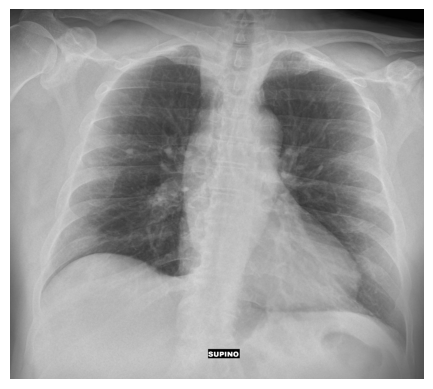

In [15]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [16]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this X-Ray image to identify signs of pneumonia."},
            {"type": "image", "image": image},
        ]
    }
]

In [17]:
output = pipe(text=messages, max_new_tokens=256)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


In [18]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the provided supine chest X-ray, I can observe the following:

*   **Lung Fields:** The lung fields appear relatively clear without obvious consolidation or opacities.
*   **Heart Size:** The heart size appears within normal limits.
*   **Mediastinum:** The mediastinum appears unremarkable.
*   **Bones:** The ribs and vertebral bodies appear intact.

However, without further information, it's difficult to definitively rule out pneumonia. This is due to the limitations of a single chest X-ray in detecting subtle findings. Some possible limitations are:

*   **Early Pneumonia:** Early pneumonia may not always show definitive consolidation on a chest X-ray.

If the patient has a high clinical suspicion for pneumonia (e.g., fever, cough, shortness of breath), additional imaging modalities, such as a CT scan of the chest, may be necessary for a more accurate diagnosis. In addition, clinical findings should be considered along with the radiographic findings to formulate a diagnosis.

Therefore, while the X-ray is not highly suggestive of pneumonia, I cannot definitively rule it out.


# Brain MRI scans

We are looking next to selections from a Brain Tumor MRI dataset.

In [19]:
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0012.jpg"
image = Image.open(image_path)

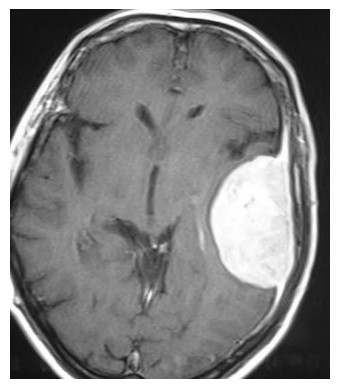

In [20]:
plt.imshow(image)
plt.axis('off') 
plt.show()

In [21]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Analyze this image, identify the modality and suggest diagnosis."},
            {"type": "image", "image": image},
        ]
    }
]

In [22]:
output = pipe(text=messages, max_new_tokens=256)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


In [23]:
display(Markdown(output[0]["generated_text"][-1]["content"]))

Based on the image, the modality is likely **Magnetic Resonance Imaging (MRI)**. The image exhibits characteristic features of MRI, including:

*   **Soft tissue contrast:** The brain tissue appears with excellent detail, differentiating between gray and white matter, sulci, and ventricles. This is a hallmark of MRI.
*   **Signal characteristics:** The different brain structures have varying signal intensities (hyperintense/hypointense) on T1 and T2-weighted sequences, which can be further evaluated to aid in diagnosis.
*   **Absence of ionizing radiation:** Unlike CT scans, MRI does not use ionizing radiation.

**Possible Diagnosis:**

Given the appearance of a large, enhancing mass with surrounding edema, the most likely diagnosis is a **Brain Tumor**.

The presence of a fluid-filled space (likely a cyst or hydrocephalus) and the enhancing nature of the mass suggests a possible **meningioma** (especially if located in the posterior fossa) or other type of space-occupying lesion such as a metastatic lesion, primary brain tumor (e.g., glioblastoma, meningioma), or a less likely possibility like a vascular malformation (e.g., arteriovenous malformation, AVM).

A

# Conclusions


This specialized model from Google DeepMind allows interpretation of a variety of medical images.   
We looked to X-Ray images for chest, MRI scan slices for brain, and skin melanoma images.

While the amount of details and specificity of medical comments is impressive, the model is also providing clear information that its output it is not to be used as a definitive medical diagnosys.
